### 00 Install segment anything

source: https://maxjoas.medium.com/finetune-segment-anything-sam-for-images-with-multiple-masks-34514ee811bb

In [ ]:
# !pip install segment_anything

### Import packages

In [ ]:


from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import glob
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

import json
import toml
import os
import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
from pycocotools.coco import COCO
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from torch.utils.data import DataLoader, Dataset
import logging
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:

from torch.types import Device
#data
global train
global test
global annot

# TODO: Put your path here !!!!
# train_path = "/workspace/raid/OM_DeepLearning/XMM_OM_code_git/dog-2/train"
# test = "/workspace/raid/OM_DeepLearning/XMM_OM_code_git/dog-2/test"

train_path = "/workspace/raid/OM_DeepLearning/XMM_OM_code_git/-xmm_om_images_v4-contrast-512-5-2/train"
test = "/workspace/raid/OM_DeepLearning/XMM_OM_code_git/-xmm_om_images_v4-contrast-512-5-2/train/"

annot_train = "_annotations.coco.json"
annot_test = "_annotations.coco.json"

#model
global batch_size
global epochs
global lr
global weight_decay
global DEVICE

# TODOD adjust, if needed!!!!
batch_size = 1
epochs = 1
lr = 0.001
weight_decay = 0.00005
DEVICE = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# loss
global alpha
global gamma
alpha = 0.8
gamma = 2

In [ ]:
iter_1_repr_images = [#'S0111200201_S', 
                                'S0414380901_V_png.rf.af973c8a0bf59679a9537a68e1af3b2d.jpg', 
                                'S0728360101_M_png.rf.53711bf6706b927adbcfc5c8b14100d4.jpg', 
                                'S0651790101_M_png.rf.db68eba9e94fd6505eefacb9fa3301aa.jpg', 
                                'S0844430201_L_png.rf.b761534d487edaec220bc29ce2e5cb9f.jpg',
                                'S0205510401_M_png.rf.6f256ac1e8b7d36259a57ffde6208aab.jpg',
                                'S0725290157_L_png.rf.1eb28d89ee137c739c48d39fd20e4fa8.jpg',
                                'S0112260201_L_png.rf.6a52b5c55a524a577af1d51a6a894f5c.jpg',
                                'S0065820601_M_png.rf.71af28e2772b1bab657c6e585d840abd.jpg',
                                'S0112681301_L_png.rf.db0e33f14ba120bd599ddd9c66f86880.jpg',
                                'S0827230401_M_png.rf.073265141f24734da9e6a88f9ebdaee7.jpg', # ROS
                                'S0112680801_L_png.rf.9481cb81300d33e79f877d572e6162a6.jpg', # ROS
                                'S0402430401_U_png.rf.961308f9c5796636182db1455c6ddaed.jpg', # ROS
                                'S0506340101_L_png.rf.7511ae9b99d0a63a0c954763530917ae.jpg', #ROS
                                'S0506340101_L_png.rf.7511ae9b99d0a63a0c954763530917ae.jpg', 
                                'S0655340135_L_png.rf.570a562141d45991c8f4935dfe7b3877.jpg', #ROS
                                'S0300890101_U_png.rf.d929d6c991617f4575e4773247aa1c5a.jpg', 
                                'S0677840141_L_png.rf.7258cc2f40ad3454f04bc581a9c3ca9a.jpg',
                                'S0655340140_L_png.rf.1c7ffe7b6168ad9cdb4dde1fbb2a8a3d.jpg', 
                                'S0201510101_M_png.rf.2e767022dd7c923948a21df7a47a92fa.jpg', 
                                'S0862090101_U_png.rf.61bf3459a21f2bf38e746c69ccd6db20.jpg', 
                                'S0110010701_S_png.rf.e4030682302dc037bc7ed14318c42c91.jpg', 
                                'S0414190701_U_png.rf.14a225508497ebedfb08628f5181ba82.jpg', 
                                'S0134921101_B_png.rf.4f2fdf08afea257413568ecba13d9421.jpg', 
                                'S0677820144_L_png.rf.3938bcbe21e6bd27ddc354123a96ec3f.jpg', 
                                'S0554750401_M_png.rf.ebf8b2f9a1f1e83caa1ce59d94cb6b42.jpg', 
                                'S0601930601_L_png.rf.a708cd8cb21291b6c47da17bf007dbf1.jpg', 
                                'S0610000201_L_png.rf.b63fa639aa370f0ab54ee5532b955ab3.jpg', 
                                'S0125911501_V_png.rf.a615cc89c36c5c43a6eb031da173dc46.jpg', 
                                'S0725290148_L_png.rf.1ea5685ce324a1c741e727e65486e188.jpg', 
                                'S0677800134_L_png.rf.4edc692f0dba644be7c82dc07067dea2.jpg',
                                'S0203540701_U_png.rf.57fd1b4861d1fe3ea1f56b603a6aec60.jpg', 
                                'S0741032901_L_png.rf.aaeb5e8a293a1885fab80f116dac8ae7.jpg',
                                'S0747420139_L_png.rf.5c4c0bce4e793a2e705ce0641353fd5d.jpg',
                                'S0404350101_S_png.rf.1bbcd48cc90226b9f02988dbe870b1a7.jpg', 
                                'S0105460201_S_png.rf.893cd2920d2e190b3bd4b9b46df9e7b6.jpg', 
                                'S0840131201_L_png.rf.6f3c86b8e62c8db18d8c291c6a144bf7.jpg']

In [ ]:
#putem them into another file

# import shutil

# for filename in iter_1_repr_images:
#     src_path = os.path.join('./-xmm_om_images_v4-contrast-512-5-2/train/', filename)
#     dst_path = os.path.join('./repr_images_1/', filename)
    
#     shutil.copy(src_path, dst_path)

In [ ]:
iter_1_repr_images

In [ ]:
print(len(iter_1_repr_images))

In [ ]:
# import json

# # extract annotations for images given filenames and json annotations file
# with open('./-xmm_om_images_v4-contrast-512-5-2/train/_annotations.coco.json', 'r') as f:
#     coco_data = json.load(f)

# # Filter the images to keep only those with filenames in image_filenames
# filtered_images = [image for image in coco_data['images'] if image['file_name'] in iter_1_repr_images]
# print(filtered_images)
# # Collect IDs of the filtered images
# img_ids = [image['id'] for image in filtered_images]

# # Filter the annotations to keep only those associated with the filtered image IDs
# filtered_annotations = [annotation for annotation in coco_data['annotations'] if annotation['image_id'] in img_ids]

# # Update the original COCO data structure with filtered data
# coco_data['images'] = filtered_images
# coco_data['annotations'] = filtered_annotations

# # Optionally, filter categories to keep only those used in the filtered annotations
# used_category_ids = set(annotation['category_id'] for annotation in filtered_annotations)
# filtered_categories = [category for category in coco_data['categories'] if category['id'] in used_category_ids]
# coco_data['categories'] = filtered_categories

# # Save the modified data to a new JSON file
# with open('./repr_images_1/_annotations.coco.json', 'w') as f:
#     json.dump(coco_data, f, indent=4)

### Take a first look at the data

In [ ]:
# TODO add your path
sample_path = "/workspace/raid/OM_DeepLearning/XMM_OM_code_git/-xmm_om_images_v4-contrast-512-5-2/train/S0673730101_U_png.rf.fdeb357e1e274430b141f56d811dad49_augm3.jpg"
sample_img = cv2.imread(sample_path)
plt.imshow(sample_img)

## 01 Segment image with SAM

In [ ]:

from typing import List, Dict, Any
def build_totalmask(pred: List[Dict[str, Any]]) -> np.ndarray:
    """Builds a total mask from a list of segmentations
    ARGS:
        pred (list): list of dicts with keys 'segmentation' and others
    RETURNS:
        total_mask (np.ndarray): total mask

    """

    total_mask = np.zeros(pred[0]['segmentation'].shape, dtype=np.uint8)
    for seg in pred:
        total_mask += seg['segmentation']
    # use cv2 to make image black and white
    _, total_mask = cv2.threshold(total_mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


    return total_mask


In [ ]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

sam = sam_model_registry["vit_h"](checkpoint="./sam_vit_h_4b8939.pth") #TODO your path here
mask_generator = SamAutomaticMaskGenerator(sam)
sam.to(DEVICE)
masks = mask_generator.generate(sample_img)
print(type(masks))

In [ ]:
print(len(masks))
print(type(masks[0]))
print(f'keys of dict: {masks[0].keys()}')

In [ ]:
print(f"Shape of masks: {masks[0]['segmentation'].shape}")
print('Value counts in segmentation of first mask:')
print(np.unique(masks[0]['segmentation'], return_counts=True))

In [ ]:
total_mask = build_totalmask(masks)
plt.imshow(total_mask, cmap='gray')

When you use the web app of SAM, you might notice, that you need to provide a prompt (i.e. point with your mouse where your object is) to get a result. The mask_generator does this for you, by providing a grid of points over the whole image and creating a mask for each point and then later removing duplicated and low-quality masks. See the point grid below:

In [ ]:
points = mask_generator.point_grids[0]
# plot image and lay points on it
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(sample_img)
ax.scatter(x=points[:, 0] *512, y=points[:, 1] *512, c="r", s=10)
ax.set_axis_off()
plt.show()

### Summary Segment Anything format:

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

- The mask generator uses a grid of points as prompts and generates masks for each point.[see here](https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py)

- The coco annotations categories is a list of dictionaries with keys:
  * `id` - the id of the class
  * `name` - the name corresponding to the id
  * `supercategory` 

In [44]:
import numpy as np
from torchvision.transforms.functional import resize


class COCODataset(Dataset):
    """
    A PyTorch Dataset to load data from a json file in COCO format.

    ...
    Attributes
    ----------
    root_dir : str
        the root directory containing the images and annotations
    annotation_file : str
        name of the json file containing the annotations (in root_dir)
    transform : callable
        a function/transform to apply to each image

    Methods
    -------
    __getitem__(idx)
        returns the image, image path, and masks for the given index
    buid_total_mask(masks)
        combines the masks into a single mask
    """


    def __init__(self, root_dir, annotation_file, transform=None, split=None, percentage=None):

        assert (split is None and percentage is None) or (split is not None and percentage is not None), "Either both split and percentage should be None or neither."
        assert (split=='train') or (split=='val'), "Specify the split by using 'train' or 'val' keywords."
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(annotation_file)
        self.image_ids_1 = list(self.coco.imgs.keys())
        self.categories = self.coco.loadCats(self.coco.getCatIds()) 
        # Filter out image_ids without any annotations
        self.image_ids_1 = [image_id for image_id in self.image_ids_1 if len(self.coco.getAnnIds(imgIds=image_id)) > 0]
        self.categories = {self.categories[i]['id']: self.categories[i]['name'] for i in range(len(self.categories))} # id:name dict
        self.image_ids = []

        for idx in range(len(self.image_ids_1)):
            image_id = self.image_ids_1[idx]
            ann_ids = self.coco.getAnnIds(imgIds=image_id)
            anns = self.coco.loadAnns(ann_ids)
            good_image = False
            
            for ann in anns:
                x, y, w, h = ann['bbox']
                if w > 10 or h > 10: # filter out very small masks
                    if not self.categories[ann['category_id']].endswith('star'):
                        good_image = True
                        
            if good_image: # filter out images with no annotations again
                self.image_ids.append(image_id)

        if split == 'train':
            percentage = int(len(self.image_ids) * percentage)
            self.image_ids = self.image_ids[:percentage]
        else:
            percentage = int(len(self.image_ids) * (1-percentage))
            self.image_ids = self.image_ids[percentage:]
                

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.root_dir, image_info['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        bboxes = []
        masks = []

        for ann in anns:
            x, y, w, h = ann['bbox']

            if not self.categories[ann['category_id']].endswith('star'): # this is safe because images with only stars are already filtered out in __init__
                bboxes.append([x, y, x + w, y + h])
                mask = self.coco.annToMask(ann)
                masks.append(mask)
      
        if self.transform:
            image, masks, bboxes = self.transform(image, masks, np.array(bboxes))

        bboxes = np.stack(bboxes, axis=0)
        masks = np.stack(masks, axis=0)
        return image, image_path, torch.tensor(masks).float()

    def get_totalmask(self, masks):
        """get all masks in to one image
        ARGS:
            masks (List[Tensor]): list of masks
        RETURNS:
            total_gt (Tensor): all masks in one image

        """
        total_gt = torch.zeros_like(masks[0][0,:,:])
        for k in range(len(masks[0])):
            total_gt += masks[0][k,:,:]
        return total_gt



class ResizeAndPad:
    """
    Resize and pad images and masks to a target size.

    ...
    Attributes
    ----------
    target_size : int
        the target size of the image
    transform : ResizeLongestSide
        a transform to resize the image and masks
    """

    def __init__(self, target_size):
        self.target_size = target_size
        self.transform = ResizeLongestSide(target_size)
        self.to_tensor = transforms.ToTensor()

    def __call__(self, image, masks, bboxes):
        # Resize image and masks
        og_h, og_w, _ = image.shape

        negative_map = (np.where(image > 0, 1, 0)).astype(np.uint8)
        negative_map = torch.from_numpy(negative_map)  
        negative_map = negative_map.permute(2, 0, 1)
        negative_map = resize(negative_map, [1024, 1024], antialias=True) 
        negative_map = negative_map.to(torch.uint8)
        image = self.transform.apply_image(image)
        masks = [torch.tensor(self.transform.apply_image(mask)) for mask in masks]
        image = self.to_tensor(image)

        # Pad image and masks to form a square
        _, h, w = image.shape
        max_dim = max(w, h)
        pad_w = (max_dim - w) // 2
        pad_h = (max_dim - h) // 2

        padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
        image = transforms.Pad(padding)(image)
        masks = [transforms.Pad(padding)(mask) for mask in masks]

        image = image * negative_map # mask -ve pixels
        # print(negative_map.shape, image.shape, np.unique(negative_map.detach().cpu().numpy()))
        # plt.imshow(image[0].detach().cpu().numpy())
        # plt.show()
        # plt.close()

        # Adjust bounding boxes
        bboxes = self.transform.apply_boxes(bboxes, (og_h, og_w))
        bboxes = [[bbox[0] + pad_w, bbox[1] + pad_h, bbox[2] + pad_w, bbox[3] + pad_h] for bbox in bboxes]

        return image, masks, bboxes


def load_datasets(img_size):
    """ load the training and validation datasets in PyTorch DataLoader objects
    ARGS:
        img_size (Tuple(int, int)): image size
    RETURNS:
        train_dataloader (DataLoader): training dataset
        val_dataloader (DataLoader): validation dataset

    """
    transform = ResizeAndPad(1024)
    traindata = COCODataset(root_dir=train_path,
                        annotation_file=os.path.join(train_path, annot_train),
                        transform=transform,
                        split='train',
                        percentage=0.7)
    valdata = COCODataset(root_dir=test,
                      annotation_file=os.path.join(test, annot_test),
                      transform=transform,
                      split='val', 
                      percentage=0.3)
    train_dataloader = DataLoader(traindata,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=1)
    val_dataloader = DataLoader(valdata,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=1)
    return train_dataloader, val_dataloader


In [45]:
trainloader, validloader = load_datasets(1024)
sample_img = trainloader.dataset[0][0]
sample_mask = trainloader.dataset[0][2]

print('#train images:', len(trainloader.dataset), '#validation images:', len(validloader.dataset))

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
#train images: 121 #validation images: 53


In [ ]:
print(f'shape of sample_img: {sample_img.shape}')
print(f'shape fo sample_mask: {sample_mask.shape}')

### Summary functions and classes:
Now we have transformed our images and coco annotations to torch tensors, that we can use for training. For training (fine-tuning SAM) we need to define a Neural net with PyTorch first, we do this in the next class. It's pretty well documented, so I'll leave you with the code:

In [ ]:
import torch.nn as nn
class ModelSimple(nn.Module):
    """
    Wrapper for the sam model to to fine-tune the model on a new dataset

    ...
    Attributes:
    -----------
    freeze_encoder (bool): freeze the encoder weights
    freeze_decoder (bool): freeze the decoder weights
    freeze_prompt_encoder (bool): freeze the prompt encoder weights
    transform (ResizeLongestSide): resize the images to the model input size

    Methods:
    --------
    setup(): load the model and freeze the weights
    forward(images, points): forward pass of the model, returns the masks and iou_predictions
    """

    def __init__(self, freeze_encoder=True, freeze_decoder=False, freeze_prompt_encoder=True):
        super().__init__()
        self.freeze_encoder = freeze_encoder
        self.freeze_decoder = freeze_decoder
        self.freeze_prompt_encoder = freeze_prompt_encoder
        # we need this to make the input image size compatible with the model
        self.transform = ResizeLongestSide(1024) #This is 1024, because sam was trained on 1024x1024 images

    def setup(self, MODEL_TYPE, chekpoint):
        self.model = sam_model_registry[MODEL_TYPE](chekpoint)
        # to speed up training time, we normally freeze the encoder and decoder
        if self.freeze_encoder:
            for param in self.model.image_encoder.parameters():
                param.requires_grad = False
        if self.freeze_prompt_encoder:
            for param in self.model.prompt_encoder.parameters():
                param.requires_grad = False
        if self.freeze_decoder:
            for param in self.model.mask_decoder.parameters():
                param.requires_grad = False
        self.transfrom = ResizeLongestSide(self.model.image_encoder.img_size)
        
    def forward(self, images, negative_maps):

        # print('images shape:', images.shape)
        _, _, H, W = images.shape # batch, channel, height, width - well, batch_size cannot be greater than 1 apparently
        
        image_embeddings = self.model.image_encoder(images) # shape: (1, 256, 64, 64)
        # get prompt embeddings without acutally any prompts (uninformative)
        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
        )

        # get low resolution masks and iou predictions
        # mulitmask_output=False means that we only get one mask per image,
        # otherwise we would get three masks per image
        low_res_masks, iou_predictions = self.model.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=self.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings, # sparse_embeddings shape: (1, 0, 256)
            dense_prompt_embeddings=dense_embeddings, # dense_embeddings shape: (1, 256, 256)
            multimask_output=True,
        )
        # postprocess the masks to get the final masks and resize them to the original image size
        masks = F.interpolate(
            low_res_masks, # shape: (1, 1, 256, 256)
            (H, W),
            mode="bilinear",
            align_corners=False,
        )
        
        masks = masks * negative_maps

        # print(masks.shape)
        # shape masks after interpolate: torch.Size([1, 1, 1024, 1024])
        return masks, iou_predictions

In [ ]:
# model = ModelSimple()
# model.setup('vit_h', './sam_vit_h_4b8939.pth')
# img_size = model.model.image_encoder.img_size
# print(img_size)

## Association algorithms

In [ ]:
import torch
from scipy.optimize import linear_sum_assignment

def compute_iou_tensor(mask1, mask2):
    """
    Compute the Intersection over Union (IoU) of two binary masks represented as PyTorch tensors.
    """
    intersection = torch.logical_and(mask1, mask2).sum().item()
    union = torch.logical_or(mask1, mask2).sum().item()
    if union == 0:
        return 0
    else:
        return intersection / union

def associate_masks_tensor(predicted_masks, target_masks):
    """
    Associate each predicted mask with a target mask using the Hungarian algorithm.
    Assumes inputs are lists of PyTorch tensors.
    """
    num_predicted = len(predicted_masks)
    num_targets = len(target_masks)
    
    # Calculate the IoU between each pair of predicted and target mask
    iou_matrix = torch.zeros(num_predicted, num_targets)
    for i, pred_mask in enumerate(predicted_masks):
        for j, target_mask in enumerate(target_masks):
            iou_matrix[i, j] = compute_iou_tensor(pred_mask, target_mask)
    
    # Convert IoU matrix to NumPy for linear_sum_assignment
    iou_matrix_np = iou_matrix.numpy()
    row_ind, col_ind = linear_sum_assignment(1 - iou_matrix_np)
    
    # Filter out assignments with no overlap
    matched_indices = [(r, c) for r, c in zip(row_ind, col_ind) if iou_matrix[r, c] > 0]
    
    return matched_indices, iou_matrix

# # Example usage with tensor masks
# predicted_masks = [torch.randint(0, 2, (100, 100), dtype=torch.bool) for _ in range(5)]
# target_masks = [torch.randint(0, 2, (100, 100), dtype=torch.bool) for _ in range(4)]

# matched_indices, iou_scores_tensor = associate_masks_tensor(predicted_masks, target_masks)

# for pred_idx, target_idx in matched_indices:
#     print(f"Predicted Mask {pred_idx} is matched with Target Mask {target_idx} with IoU {iou_scores_tensor[pred_idx, target_idx]:.2f}")


## Models, classes functions for fine-tuning

In [32]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import tqdm
from tqdm import tqdm
import time

def get_totalmask(masks):
    """get all masks in to one image
    ARGS:
        masks (torch.Tensor): shape: (N, H, W) where N is the number of masks
                              masks H,W is usually 1024,1024
    RETURNS:
        total_gt (torch.Tensor): all masks in one image

    """
    total_gt = torch.zeros_like(masks[0,:,:])
    for k in range(len(masks)):
        total_gt += masks[k,:,:]
    return total_gt



class FocalLoss(nn.Module):
    """ Computes the Focal loss. """

    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets):

        inputs = inputs.flatten(0,2)
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1 - BCE_EXP)**gamma * BCE

        return focal_loss


class DiceLoss(nn.Module):
    """ Computes the Dice loss. """

    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)
        inputs = inputs.flatten(0,2)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / \
            (inputs.sum() + targets.sum() + smooth)
        return 1 - dice



def criterion(x, y):
    """ Combined dice and focal loss.
    ARGS:
        x: (torch.Tensor) the model output
        y: (torch.Tensor) the target
    RETURNS:
        (torch.Tensor) the combined loss

    """
    focal, dice = FocalLoss(), DiceLoss()
    y = y.to(DEVICE)
    x = x.to(DEVICE)
    return 1e4 * (20 * focal(x, y) + dice(x, y))


def train_one_epoch(model, trainloader, optimizer, epoch_idx):
    """ Runs forward and backward pass for one epoch and returns the average
    batch loss for the epoch.
    ARGS:
        model: (nn.Module) the model to train
        trainloader: (torch.utils.data.DataLoader) the dataloader for training
        optimizer: (torch.optim.Optimizer) the optimizer to use for training
        epoch_idx: (int) the index of the current epoch
        tb_writer: (torch.utils.tensorboard.writer.SummaryWriter) the tensorboard writer
    RETURNS:
        last_loss: (float) the average batch loss for the epoch

    """
    running_loss = 0.
    for i, (image, path, masks) in tqdm(enumerate(trainloader)):
        orig_image = cv2.imread(path[0])
        orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        negative_map = (np.where(orig_image > 0, 1, 0)).astype(np.uint8)
        negative_map = torch.from_numpy(negative_map)  
        negative_map = negative_map.permute(2, 0, 1)
        negative_map = resize(negative_map, [1024, 1024], antialias=True) 
        negative_map = negative_map.to(torch.uint8).squeeze(0).to(DEVICE)
        del orig_image
        image = image.to(DEVICE)
        optimizer.zero_grad()
        pred, _ = model(image, negative_map)
        masks = masks[0].to(DEVICE) # (number of masks, 1024, 1024)

        # # match predicted with ground truth masks (using the Hungarian method)
        # matched_indices, iou_scores_tensor = associate_masks_tensor(pred, masks)
        # print(matched_indices, iou_scores_tensor)
        total_mask = get_totalmask(masks)
        a_mask_on_prediction = total_mask > 0.0 # the predicted total mask will ignore stars and other non-annotated objects from prediction
        pred[0][0] = pred[0][0] * a_mask_on_prediction
        pred = pred.to(DEVICE)
        loss = criterion(pred[0][0].unsqueeze(0).unsqueeze(0), total_mask)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        binary_pred_mask = ((pred.detach().cpu().numpy()[0]) > 0.0).astype(int)

        for name, parameter in model.named_parameters():
                if parameter.grad is not None: 
                    grad_norm = parameter.grad.norm()
                    if grad_norm < 1e-8: 
                        print(f'❗️Layer {name} has vanishing gradients: {grad_norm}')
                        
        fig, axs = plt.subplots(1, 3)
        
        axs[0].imshow(image[0].permute(1,2,0).detach().cpu().numpy())
        axs[0].axis('off')
    
        axs[1].imshow(total_mask.detach().cpu().numpy())
        axs[1].set_title('Ground truth masks', fontsize=10)
        axs[1].axis('off')
        
        # axs[2].imshow(pred.detach().cpu().numpy()[0][0])
        axs[2].imshow(binary_pred_mask[0])
        axs[2].set_title('Predicted masks', fontsize=10)
        axs[2].axis('off')
        # plt.savefig('on_img_train.png', dpi=300)
    
        plt.show()
        plt.close()


    i = len(trainloader)
    last_loss = running_loss / i
    # print(f'batch_loss for batch {i}: {last_loss}')
    tb_x = epoch_idx * len(trainloader) + i + 1
    # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
    running_loss = 0.
    return last_loss


def train(n_epochs_stop):
    """ Trains the model for the given number of epochs."""
    bestmodel_path = ""
    model = ModelSimple()
    model.setup('vit_h', './sam_vit_h_4b8939.pth')

    model.load_state_dict(torch.load('model_final.pth'))
    model.to(DEVICE)
    img_size = model.model.image_encoder.img_size
    trainloader, validloader = load_datasets(img_size=img_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_valid_loss = float('inf')

    train_losses, valid_losses = [], []
    for epch in range(epochs): # type: ignore
        #train
        running_vloss = 0.
        model.train(True)
        avg_batchloss = train_one_epoch(
            model, trainloader, optimizer, epch)
        print(f'epoch: {epch}, train loss: {avg_batchloss}.')
        train_losses.append(avg_batchloss)
        # validate
        eval = False
        
        if not eval: # type: ignore
            continue
        with torch.no_grad():
            for images, path, masks in validloader:
                model.to(DEVICE)
                images = images.to(DEVICE)
                masks = masks[0].to(DEVICE)
                total_mask = get_totalmask(masks)
                total_mask = total_mask.to(DEVICE)
                model.eval()
                preds, iou = model(images)
                preds = preds.to(DEVICE)
                vloss = criterion(preds, total_mask)
                running_vloss += vloss.item()
        avg_vloss = running_vloss / len(validloader)
        valid_losses.append(avg_vloss)
        
        # save model
        print(f'epoch: {epch}, validloss: {running_vloss}')
        print(f'best valid loss: {best_valid_loss}')
        if running_vloss < best_valid_loss:
            best_valid_loss = running_vloss
            best_model = model
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == n_epochs_stop:
                print("Early stopping initiated.")
                early_stop = True
                break
     
    return model, train_losses, valid_losses

# next add train function for prompting model with points (ModelAll)
# next unrelated find out how to get tensor output of masks form SamAutomaticMaskGenerator

### Train

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


0it [00:00, ?it/s]

❗️Layer model.mask_decoder.transformer.layers.0.self_attn.k_proj.bias has vanishing gradients: 1.801049642757846e-09
❗️Layer model.mask_decoder.transformer.layers.1.self_attn.k_proj.bias has vanishing gradients: 3.4365927881196967e-09
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.0.weight has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.0.bias has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.1.weight has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.1.bias has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.2.weight has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.2.bias has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.2.layers.0.weight has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.2.layers.0.bias ha

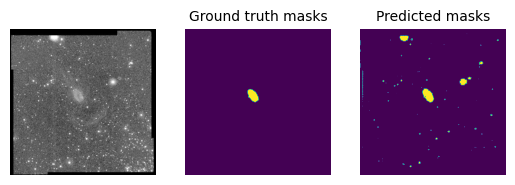

1it [00:00,  1.00it/s]

❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.0.weight has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.0.bias has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.1.weight has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.1.bias has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.2.weight has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.2.bias has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.2.layers.0.weight has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.2.layers.0.bias has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.2.layers.1.weight has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.2.layers.1.bias has vanishing gradients: 0.0
❗️Layer mo

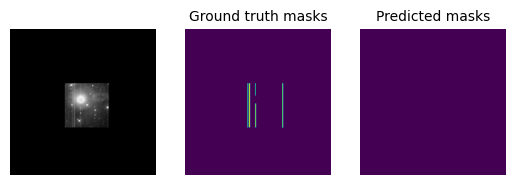

2it [00:01,  1.05it/s]

❗️Layer model.mask_decoder.transformer.layers.0.self_attn.k_proj.bias has vanishing gradients: 2.6562154697984397e-09
❗️Layer model.mask_decoder.transformer.layers.1.self_attn.k_proj.bias has vanishing gradients: 3.098806544699073e-09
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.0.weight has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.0.bias has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.1.weight has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.1.bias has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.2.weight has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.0.layers.2.bias has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.2.layers.0.weight has vanishing gradients: 0.0
❗️Layer model.mask_decoder.output_hypernetworks_mlps.2.layers.0.bias ha

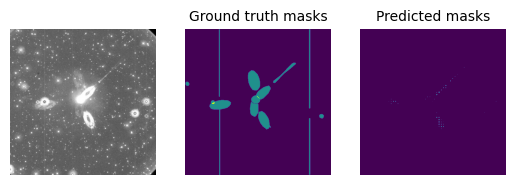

3it [00:03,  1.02s/it]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f524690dee0>
Traceback (most recent call last):
  File "/opt/conda/envs/env_py311/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/env_py311/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/envs/env_py311/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/env_py311/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/env_py311/lib/python3.11/multiprocessing/connection.py", line 947, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
 

In [33]:
model, train_losses, val_losses = train(n_epochs_stop=5)

In [ ]:
len(trainloader.dataset)

In [ ]:
print('train_losses', train_losses)
print('val_losses', val_losses)

In [ ]:
plt.plot(list(range(len(train_losses))), train_losses, label='Training Loss')
# plt.plot(list(range(len(val_losses))), val_losses, label='Validation Loss')
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./plots/amg_losses.png')
plt.show()

In [ ]:
# torch.save(model.state_dict(), f'model_final_on_36_repr_images.pth')

In [ ]:
# # sam = sam_model_registry["vit_h"](checkpoint="./sam_vit_h_4b8939.pth")
# mask_generator = SamAutomaticMaskGenerator(model.model)
# # sam.to(DEVICE)
# predicted_masks = mask_generator.generate(sample_img) # this doesn't really work this way, but rather in the way the model was fine-tuned
# print(len(predicted_masks))

# total_mask = build_totalmask(predicted_masks)
# plt.imshow(total_mask, cmap='gray')

In [ ]:
import matplotlib.pyplot as plt

# Epochs and corresponding train loss values
epochs = list(range(10))
train_loss = [
    2.111152442395687,
    1.6615700113773346,
    1.6539997470378875,
    1.6287594631314277,
    1.7573000520467759,
    1.7617580753564834,
    1.737440549135208,
    1.6835789729654789,
    1.819552083015442,
    1.759515732228756
]

# Plotting the train loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, marker='o', linestyle='-', color='b', label='Train Loss')
plt.title('Train Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()

## Predict trained model

In [ ]:
# predict trainied model
eval = False

if eval:
    model_trained = ModelSimple()
    model_trained.setup()
    with torch.no_grad():
        model_trained.load_state_dict(torch.load('model_final.pth', map_location=torch.device("cuda:7")))
        model_trained.eval()
        img_size = model_trained.model.image_encoder.img_size
        print(f'img_size: {img_size}')
        print(f'image_encoder.img_size: {model_trained.model.image_encoder.img_size}')
        running_vloss = 0.
        for images, path, masks in validloader:
    
            orig_image = cv2.imread(path[0])
            orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
            
            negative_map = (np.where(orig_image > 0, 1, 0)).astype(np.uint8)
            negative_map = torch.from_numpy(negative_map)  
            negative_map = negative_map.permute(2, 0, 1)
            negative_map = resize(negative_map, [1024, 1024], antialias=True) 
            negative_map = negative_map.to(torch.uint8).squeeze(0).to(DEVICE)
            
            # print(images)
            model.to(DEVICE)
            images = images.to(DEVICE)
            masks = masks[0].to(DEVICE)
            total_mask = get_totalmask(masks)
            total_mask = total_mask.to(DEVICE)
            model.eval()
            preds, iou = model(images, negative_map)
            preds = preds.to(DEVICE)
    
            print(preds.shape, total_mask.shape)
            
            vloss = criterion(preds[0][0].unsqueeze(0).unsqueeze(0), total_mask) # was criterion(preds, total_mask) before. i changes because the multimask_output is set on True
            running_vloss += vloss.item()
            np_image = images[0].permute(1,2,0).detach().cpu().numpy()
            np_mask = masks.detach().cpu().numpy()
            np_pred = preds[0].detach().cpu().numpy()
    
            # binary_pred_mask = ((F.sigmoid(preds[0]).cpu().numpy()[0]) > 0.5).astype(int) * 255
            binary_pred_mask = ((preds[0]).cpu().numpy()[0] > 0).astype(int) * 255
            
            print(np.mean((F.sigmoid(preds[0]).cpu().numpy()[0])), np.min((F.sigmoid(preds[0]).cpu().numpy()[0])), np.max((F.sigmoid(preds[0]).cpu().numpy()[0])))
            print(np.unique((F.sigmoid(preds[0]).cpu().numpy()[0]) > 0.5).astype(int))
            print("validation loss: ", running_vloss)
            
            fig, axs = plt.subplots(1, 3)
            
            axs[0].imshow(np_image)
            axs[0].axis('off')
        
            axs[1].imshow(get_totalmask(masks).detach().cpu().numpy())
            axs[1].set_title('Ground truth masks', fontsize=10)
            axs[1].axis('off')
            
            axs[2].imshow(binary_pred_mask)
            axs[2].set_title('Predicted masks', fontsize=10)
            axs[2].axis('off')
            # plt.savefig('on_img_train.png', dpi=300)
        
            plt.show()
            plt.close()